In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import json
import numpy as np
import random
import pandas as pd
import torch.nn.init as init

from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import ParameterGrid
from google.colab import drive

drive.mount('/content/drive')

# 재현 가능성을 위한 시드 고정
RANDOM_SEED = 18
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Dataloader 시드 고정 (아직 사용 x)

generator = torch.Generator()
generator.manual_seed(RANDOM_SEED)

def worker_init_fn(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

# DataLoader(worker_init_fn=worker_init_fn)


# 데이터 경로 설정
train_csv_path = "/content/drive/MyDrive/Samsung_AI_challenge/Data/train.csv"
test_csv_path = "/content/drive/MyDrive/Samsung_AI_challenge/Data/test.csv"
submission_csv_path = '/content/drive/MyDrive/Samsung_AI_challenge/Data/sample_submission.csv'

# 기타 경로 설정 : 저장되는 데이터 이름 등 (model, method 에 맞게 설정)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
class MLP5Hidden(nn.Module):
    def __init__(self, input_size=11, hidden_sizes=[64, 64, 64, 64, 64], output_size=1):
        super(MLP5Hidden, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_sizes[0])
        self.fc2 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
        self.fc3 = nn.Linear(hidden_sizes[1], hidden_sizes[2])
        self.fc4 = nn.Linear(hidden_sizes[2], hidden_sizes[3])
        self.fc5 = nn.Linear(hidden_sizes[3], hidden_sizes[4])
        self.fc6 = nn.Linear(hidden_sizes[4], output_size)
        self.prelu = nn.PReLU()

        self.apply(self._init_weights)

    def _init_weights(self, layer):
        if isinstance(layer, nn.Linear):
            init.xavier_uniform_(layer.weight)
            if layer.bias is not None:
                init.zeros_(layer.bias)

    def forward(self, x):
        x = self.prelu(self.fc1(x))
        x = self.prelu(self.fc2(x))
        x = self.prelu(self.fc3(x))
        x = self.prelu(self.fc4(x))
        x = self.prelu(self.fc5(x))
        x = self.fc6(x)

        return x

In [ ]:
# 훈련 데이터를 훈련 + 검증 데이터로 나누고 train_dataset, val_dataset 을 반환하는 함수
def split_dataloader(train_csv_path, val_ratio=0.2, random_state=RANDOM_SEED):
    train_data = pd.read_csv(train_csv_path)

    X = torch.tensor(train_data.iloc[:,1:-1].values, dtype=torch.float32)
    y = torch.tensor(train_data.iloc[:,-1].values, dtype = torch.float32).view(-1,1)

    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=val_ratio, random_state=random_state)

    train_dataset = TensorDataset(X_train, y_train)
    val_dataset = TensorDataset(X_val, y_val)

    return train_dataset, val_dataset

train_dataset, val_dataset = split_dataloader(train_csv_path)

In [ ]:
def test_dataloader(test_csv_path):
    test_data = pd.read_csv(test_csv_path)

    X_test = pd.read_csv(test_csv_path).iloc[:,1:].values
    X_test = torch.tensor(X_test, dtype = torch.float32)

    test_dataset = TensorDataset(X_test)

    return test_dataset

test_dataset = test_dataloader(test_csv_path)

In [ ]:
params_path = "/content/MLP5_pReLU_bestparams.json"
best_params = json.load(open(params_path, 'r'))

In [ ]:
print(best_params)

{'batch_size': 32, 'hidden_sizes': [64, 64, 64, 64, 64], 'learning_rate': 0.01}


In [ ]:
def train_test(epochs, hidden_sizes, learning_rate, batch_size):

    model = MLP5Hidden(hidden_sizes=hidden_sizes).cuda()
    criterion = nn.MSELoss().cuda()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    train_losses = []
    val_losses = []
    log = open("train_log.txt", "w")
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.cuda(), batch_y.cuda()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss = train_loss / len(train_loader)
        train_losses.append(train_loss)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                batch_X, batch_y = batch_X.cuda(), batch_y.cuda()
                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)
                val_loss += loss.item()

        val_loss = val_loss / len(val_loader)
        val_losses.append(val_loss)

        print(f'Epoch {epoch+1}/100, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')
        log.write(f'Epoch {epoch+1}/100, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}\n')

    log.close()
    model_save_path = f"MLP5_pReLU_epoch{epochs}.pth"
    torch.save(model.state_dict(), model_save_path)

    model.eval()
    test_pred = []
    with torch.no_grad():
        for batch in test_loader:
            batch_X = batch[0].cuda()
            outputs = model(batch_X)
            test_pred.extend(outputs.cpu().numpy())

    test_pred = np.array(test_pred)

    return test_pred, train_losses, val_losses

In [ ]:
epochs = 100
test_pred, train_loss, val_loss = train_test(epochs, [16, 32, 64, 32, 16], 0.001 , 64)

Epoch 1/100, Train Loss: 736.4294, Validation Loss: 19.1299
Epoch 2/100, Train Loss: 10.8910, Validation Loss: 6.1073
Epoch 3/100, Train Loss: 4.3858, Validation Loss: 4.3850
Epoch 4/100, Train Loss: 3.7810, Validation Loss: 4.2804
Epoch 5/100, Train Loss: 3.5154, Validation Loss: 3.8122
Epoch 6/100, Train Loss: 3.2901, Validation Loss: 3.6288
Epoch 7/100, Train Loss: 3.1610, Validation Loss: 3.6659
Epoch 8/100, Train Loss: 3.1337, Validation Loss: 3.9721
Epoch 9/100, Train Loss: 3.0632, Validation Loss: 3.4203
Epoch 10/100, Train Loss: 3.0737, Validation Loss: 3.6595
Epoch 11/100, Train Loss: 3.1156, Validation Loss: 3.4063
Epoch 12/100, Train Loss: 3.0146, Validation Loss: 3.5144
Epoch 13/100, Train Loss: 3.0716, Validation Loss: 3.3796
Epoch 14/100, Train Loss: 3.1057, Validation Loss: 3.4472
Epoch 15/100, Train Loss: 3.1325, Validation Loss: 3.5383
Epoch 16/100, Train Loss: 3.0398, Validation Loss: 3.6411
Epoch 17/100, Train Loss: 3.0921, Validation Loss: 3.4746
Epoch 18/100, Train

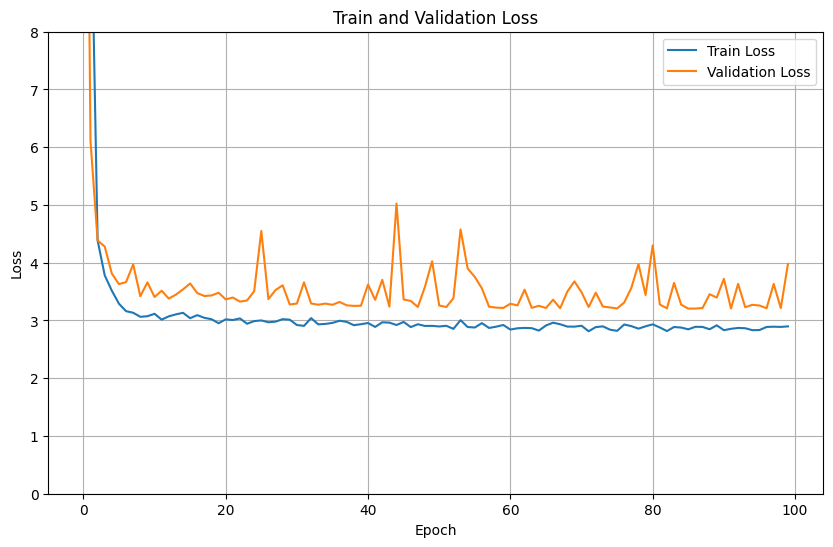

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.ylim(0, 8)
plt.legend()
plt.grid(True)
plt.savefig(f'loss.png')
plt.show()

In [ ]:
# 상위 10% 임계값 계산
threshold = np.percentile(test_pred, 90)
top_10_percent_mask = test_pred >= threshold

# 제출 파일 생성
submission_df = pd.read_csv(submission_csv_path)
submission_df['y'] = test_pred
submission_df.to_csv(f'MLP5_pReLU_Xavier_sp_epoch{epochs}.csv', index=False)

# 결과 저장
log_file_path = 'TOP10_threshold.txt'
with open(log_file_path, 'w') as log_file:
    log_file.write(f"Top 10% threshold: {threshold:.4f}\n")

# 결과 출력
print(f"Top 10% threshold: {threshold:.4f}")
print(f"Number of samples in top 10%: {sum(top_10_percent_mask)}")

Top 10% threshold: 90.1005
Number of samples in top 10%: [499]
